In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [6]:
!ls ../data

budapest_connectome_3.0_209_0_median.graphml
budapest_connectome_3.0_209_0_median_20k.csv
budapest_connectome_3.0_209_0_median_fc_20k.csv
budapest_connectome_3.0_238_0_median_1m.csv
budapest_connectome_3.0_238_0_median_fc_1m.csv
budapest_connectome_3.0_239_0_median_200k.csv
budapest_connectome_3.0_239_0_median_fc_200k.csv


In [13]:
# Load the data from the provided CSV file
# current_dir = 
count_file_path = f'data/budapest_connectome_3.0_209_0_median_fc.csv'
length_file_path = f'data/budapest_connectome_3.0_209_0_median.csv'

df_count = pd.read_csv(count_file_path, delimiter=';')
df_len = pd.read_csv(length_file_path, delimiter=';')

In [14]:
df_count.head()

,id node1,id node2,name node1,name node2,parent id node1,parent id node2,parent name node1,parent name node2,edge confidence,edge weight(med nof)
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,25.0
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,5.0
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,8.0
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,6.0
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,3.0


In [15]:
df_len.head()

,id node1,id node2,name node1,name node2,parent id node1,parent id node2,parent name node1,parent name node2,edge confidence,edge weight(med flm)
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011


In [18]:
df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})
df_merged.head()

,node1,node2,fiber_count,fiber_length
0,9,37,25.0,22.239342
1,9,37,25.0,26.385718
2,9,37,25.0,36.416003
3,9,37,25.0,32.376669
4,9,37,25.0,27.144929


In [19]:
l = df_merged["node1"].astype('int')
max(l)

83

In [20]:
# Extract the necessary information
nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
num_nodes = len(nodes)
edges = list(zip(df_merged['node1'], df_merged['node2']))

print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

# nodes:76, # edges:11288


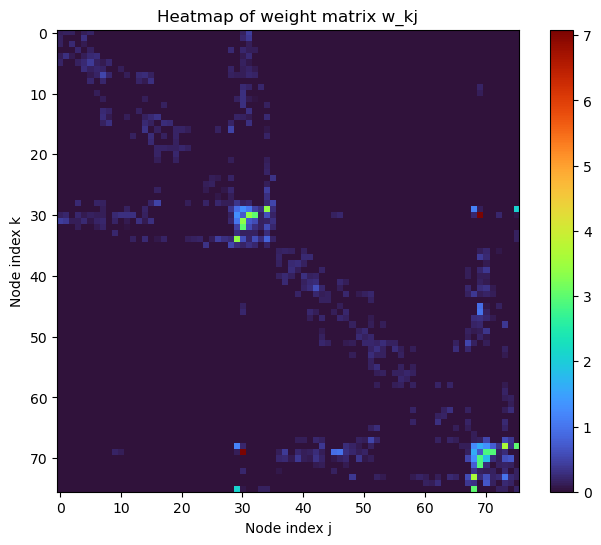

In [22]:
# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

w_kj = np.zeros((num_nodes, num_nodes))
        

for _, row in df_merged.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_count']/row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [2]:
def plot_connectivity(count_file_path, length_file_path):
    df_count = pd.read_csv(count_file_path, delimiter=';')
    df_len = pd.read_csv(length_file_path, delimiter=';')

    df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

    df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
    df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})

    l = df_merged["node1"].astype('int')
    print(f"Max node id{max(l)}")

    # Extract the necessary information
    nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
    num_nodes = len(nodes)
    edges = list(zip(df_merged['node1'], df_merged['node2']))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

    # Create a mapping from node ID to index
    node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

    w_kj = np.zeros((num_nodes, num_nodes))
            

    for _, row in df_merged.iterrows():
        idx1 = node_to_index[row['node1']]
        idx2 = node_to_index[row['node2']]
        weight = row['fiber_count']/row['fiber_length']
        w_kj[idx1, idx2] = weight
        w_kj[idx2, idx1] = weight

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(w_kj, cmap='turbo')
    plt.colorbar(heatmap)
    plt.title('Heatmap of weight matrix w_kj')
    plt.xlabel('Node index j')
    plt.ylabel('Node index k')
    plt.show()

## Varying fibres launched

Max node id83
# nodes:76, # edges:11288


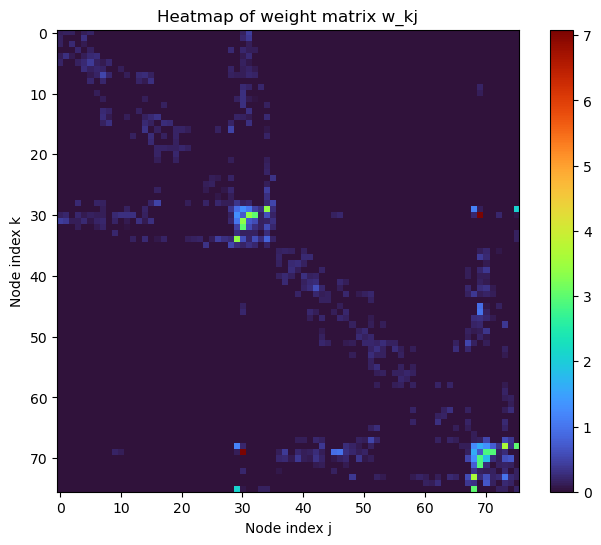

Max node id83
# nodes:81, # edges:154121


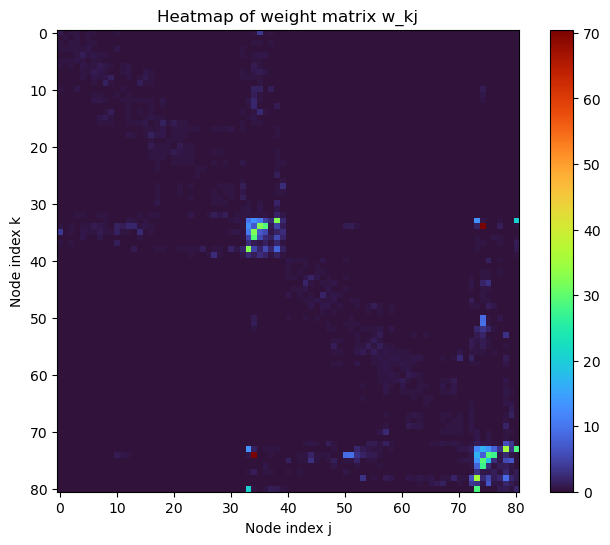

Max node id83
# nodes:81, # edges:404771


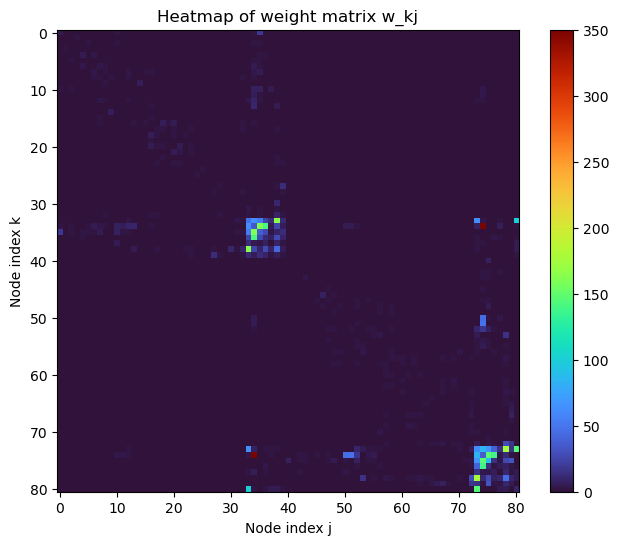

In [9]:
fibres_launched = {'20k': 209, '200k': 239, '1m': 238}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## varying edge confidence

Max node id83
# nodes:76, # edges:11288


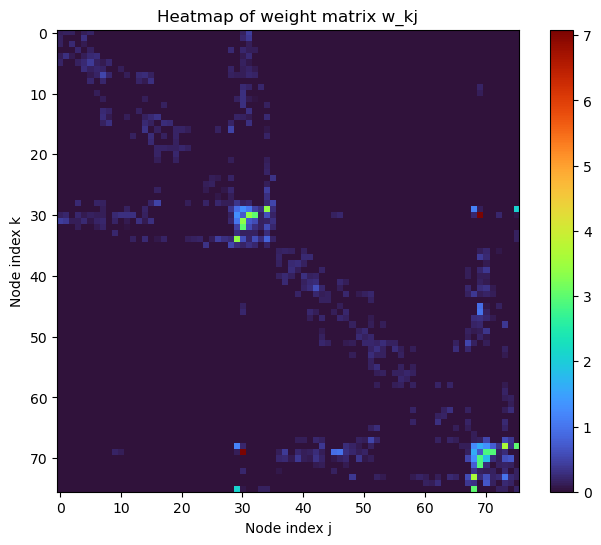

Max node id83
# nodes:78, # edges:28154


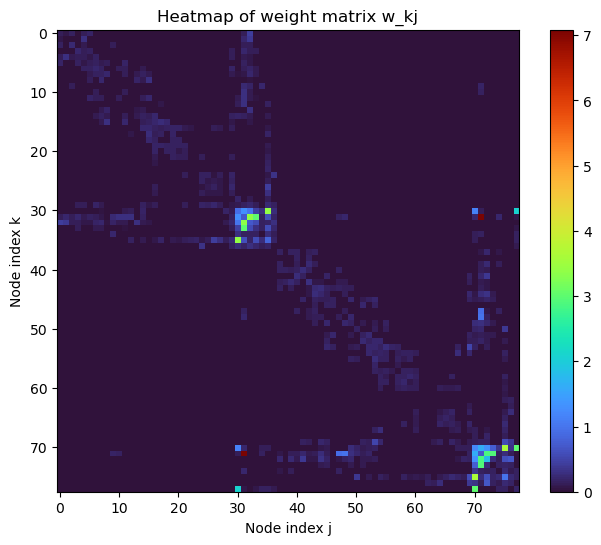

Max node id83
# nodes:83, # edges:5592725


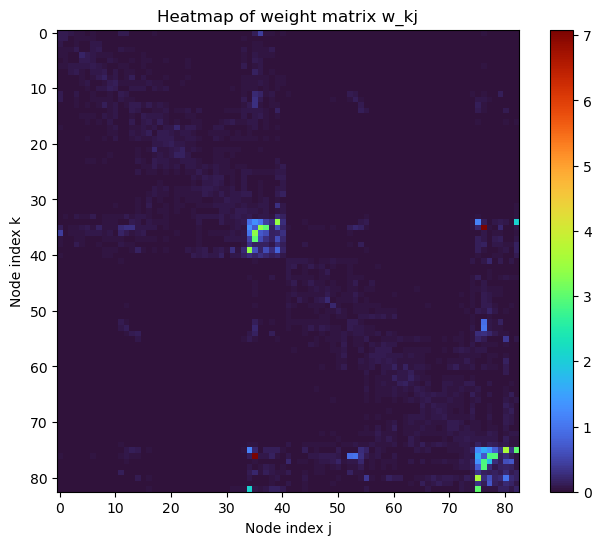

In [11]:
fibres_launched = {'20k': 209, '20k_40': 168, '20k_1':5}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_{value}_0_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Varying edge weight

Max node id83
# nodes:83, # edges:5592725


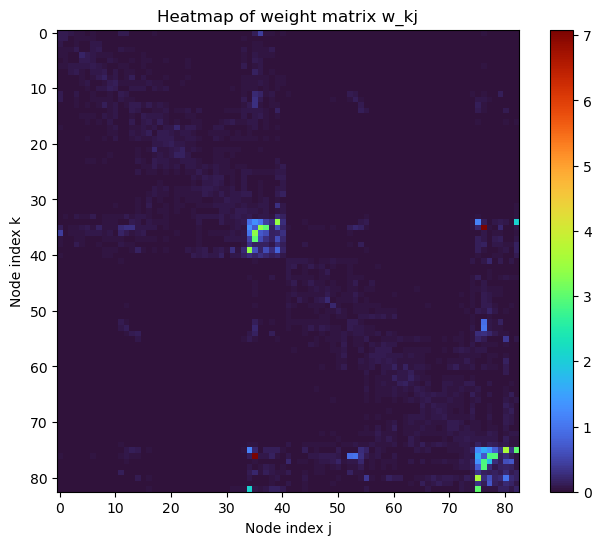

In [13]:
fibres_launched = {'20k_1':0.148}

for key, value in fibres_launched.items():
    count_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_fc_{key}.csv'
    length_file_path = f'../data/budapest_connectome_3.0_5_{value}_median_{key}.csv'

    plot_connectivity(count_file_path, length_file_path)

## Resting state dynamics

In [6]:
! ls data

budapest_connectome_3.0_209_0_median.csv
budapest_connectome_3.0_209_0_median.graphml
graph_data_1.csv
graph_data_ec.csv
graph_data_ec_1.csv
graph_data_ec_2.csv
graph_data_fc.csv


In [15]:
file_path = f'../data/budapest_connectome_3.0_209_0_median_20k.csv'
data = pd.read_csv(file_path, delimiter=';').rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med flm)':'fiber_length'})
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011


In [16]:
# Extract the necessary information
nodes = np.union1d(data['node1'].values, data['node2'].values)
num_nodes = len(nodes)
edges = list(zip(data['node1'], data['node2']))
print(num_nodes, len(edges))

w_kj = np.zeros((num_nodes, num_nodes))

# Create a mapping from node ID to index
node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

for _, row in data.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]
    weight = row['fiber_length']
    w_kj[idx1, idx2] = weight
    w_kj[idx2, idx1] = weight

76 1000


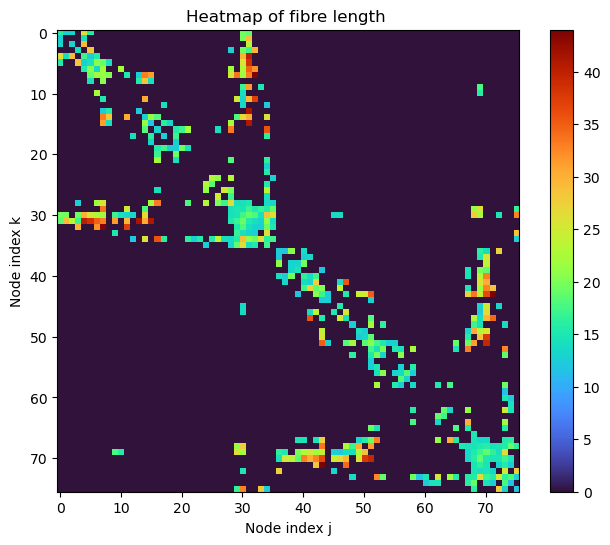

In [17]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of fibre length ')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

### Calculation and Discretisation of the delays

<Axes: xlabel='delay', ylabel='Density'>

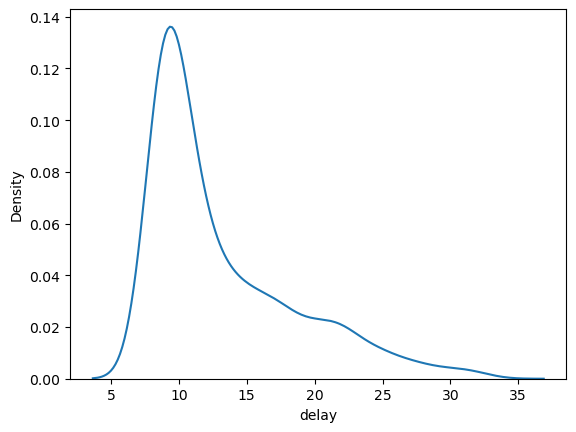

In [91]:
data['delay'] = data['fiber_length'] / 1.5
sns.kdeplot(data, x="delay")

In [92]:
data['delay_discrete'] = pd.cut(data['delay'], bins=40, labels=False)
data.head()

,id node1,id node2,name node1,name node2,node1,node2,parent name node1,parent name node2,edge confidence,fiber_length,delay,delay_discrete
0,127,504,rh.caudalmiddlefrontal_11,Right-Putamen,9,37,ctx-rh-caudalmiddlefrontal,Right-Putamen,411,22.239342,14.826228,11
1,127,145,rh.caudalmiddlefrontal_11,rh.precentral_19,9,10,ctx-rh-caudalmiddlefrontal,ctx-rh-precentral,294,18.400002,12.266668,7
2,127,131,rh.caudalmiddlefrontal_11,rh.caudalmiddlefrontal_6,9,9,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalmiddlefrontal,327,18.400001,12.266667,7
3,127,494,rh.caudalmiddlefrontal_11,rh.insula_10,9,34,ctx-rh-caudalmiddlefrontal,ctx-rh-insula,328,17.400008,11.600005,6
4,127,189,rh.caudalmiddlefrontal_11,rh.caudalanteriorcingulate_5,9,13,ctx-rh-caudalmiddlefrontal,ctx-rh-caudalanteriorcingulate,217,22.000011,14.666674,11


![alt text](image.png)

In [85]:
# Parameter dictionary
pars = {
    'lambda': -0.01,   # Decay
    'mean_omega': 40.0,       # Mean of the intrinsic frequency
    'variance_omega': 0.1,   # Variance of the intrinsic frequency noise
    'alpha': 1.0,    # Steepness of the sigmoidal function
    'dt': 0.01,      # Time step
    'T': 10.0,       # Total time
    'initial_X': 0.5,  # Some small initial condition for X
    'initial_Y': 0.5,  # Some small initial condition for Y
    'k': 10        # Coupling gain
}

In [86]:
# Update the rest of the code to use the pars dictionary
times = np.arange(0, pars['T'], pars['dt'])

np.random.seed(0)  # for reproducibility

# Random omega noise for each node
omega_noise = pars['mean_omega']+np.random.normal(0, np.sqrt(pars['variance_omega']), num_nodes)
print(omega_noise)

# Initialize the state variables
X = np.zeros((len(times), num_nodes))
Y = np.zeros((len(times), num_nodes))
X[0, :] = np.random.rand(num_nodes)  # Initial condition for X
Y[0, :] = np.random.rand(num_nodes)  # Initial condition for Y


[40.55784233 40.12654082 40.30950413 40.70863265 40.59057369 39.6909576
 40.30044434 39.95213665 39.96735933 40.12984265 40.04555058 40.45988166
 40.24066126 40.03847702 40.14036188 40.10551709 40.47246929 39.93512326
 40.0990007  39.72991121 39.19267373 40.20669235 40.27335873 39.76530681
 40.71775943 39.54008919 40.01447011 39.94080727 40.48470735 40.46465204
 40.04899868 40.11958549 39.7192575  39.37361716 39.88998052 40.04944189
 40.38905207 40.38022589 39.87751651 39.90440348 39.66841844 39.5509509
 39.46042999 40.61688935 39.83883383 39.86146874 39.60383132 40.24586404
 39.48964069 39.93272562 39.71682861 40.12234931 39.83846923 39.62665132
 39.991088   40.13545043 40.02103459 40.09565001 39.79940974 39.88529117
 39.78734933 39.88629931 39.74286057 39.45410151 40.05610707 39.87294571
 39.48448602 40.1463446  39.71308707 40.01642658 40.23055868 40.04078798
 40.36031013 39.60951379 40.1272316  39.78344403]


In [93]:
data['delay']

0      14.826228
1      12.266668
2      12.266667
3      11.600005
4      14.666674
         ...    
995    17.206059
996    10.644445
997    13.622231
998    21.733309
999     8.933333
Name: delay, Length: 1000, dtype: float64

In [108]:
# Sigmoidal function F
def S(Z):
    return 1 / (1 + np.exp(-pars['alpha'] * Z))

# Differential equations for the uncoupled system
def dXdt(X, Y, lamda_val, omega_noise):
    # coupling_sum = + pars['k']*S(w_kj*X - data['delay'])
    return lamda_val * X - omega_noise * Y - X * (X**2 + Y**2) 

def dYdt(X, Y, lamda_val, omega_noise):
    return lamda_val * Y + omega_noise * X - Y * (X**2 + Y**2)

In [123]:
## Euler integration for the coupled system
#for i in range(1, len(times)):
 #   X[i] = X[i - 1] + dXdt(X[i - 1], Y[i - 1], pars) * pars['dt']
  #  Y[i] = Y[i - 1] + dYdt(X[i - 1], Y[i - 1], pars) * pars['dt']

In [110]:
def model(y, t, lamda_val, omega_noise):    
    x_0 = y[:num_nodes]
    y_0 = y[num_nodes:2*num_nodes]

    dx_dt = dXdt(x_0, y_0, lamda_val, omega_noise)
    dy_dt = dYdt(x_0, y_0, lamda_val, omega_noise)
    
    # Merge them back into a flat array
    dydt = np.concatenate((dx_dt, dy_dt))
    return dydt


In [111]:
# Set the time points
t = np.linspace(0, 10, 1000) # From 0 to 30 years, a total of 1000 time points

# Set initial conditions
y0 = np.concatenate((X[0,:], Y[0,:]))

# No damage (β=γ=0)
sol_no_damage = odeint(model, y0, t, args=(pars['lambda'], omega_noise))

In [115]:
x_t = sol_no_damage[:, :num_nodes]
y_t = sol_no_damage[:, num_nodes:2*num_nodes]

Plotted for node 5

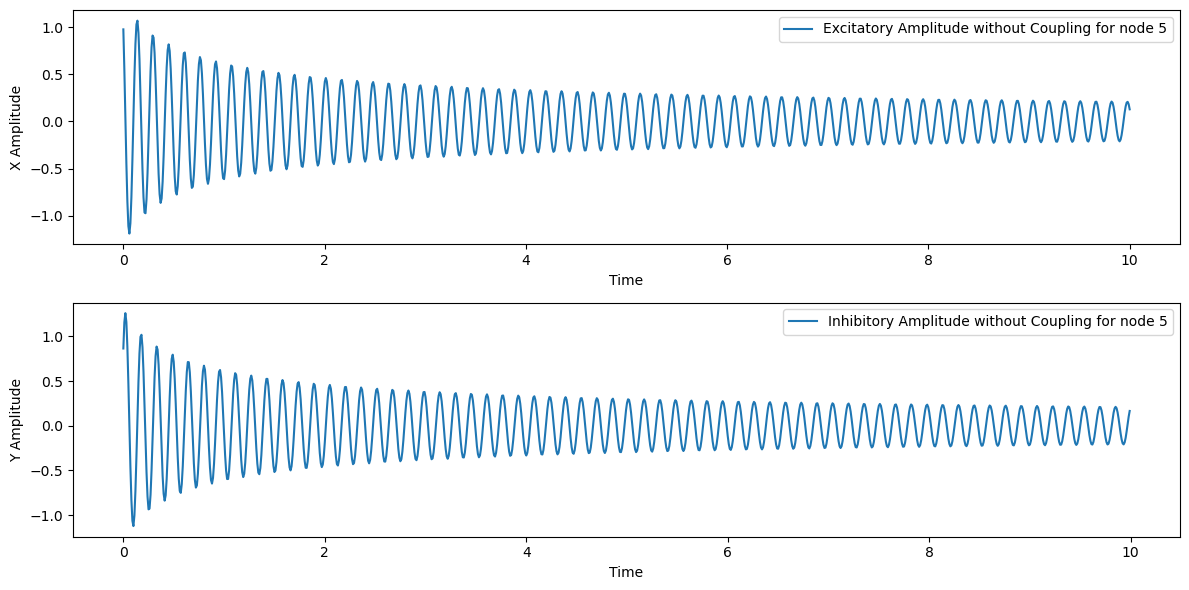

In [128]:
# Plot the results with coupling
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, x_t[:,70], label='Excitatory Amplitude without Coupling for node 5')
plt.xlabel('Time')
plt.ylabel('X Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, y_t[:,70], label='Inhibitory Amplitude without Coupling for node 5')
plt.xlabel('Time')
plt.ylabel('Y Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

For all the nodes:

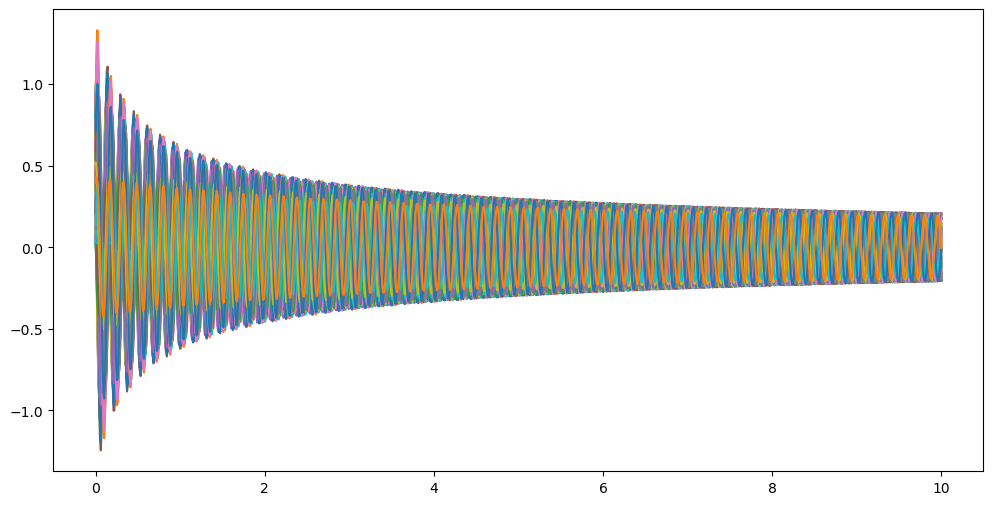

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(t, x_t)
plt.plot(t, y_t)